# Classifiers Applied to Technology Sector Data

In this notebook, we get data from `historical_stock_prices.csv` (Kaggle) and extract the technology sector. After some preprocessing, we apply various classifiers to see if any models can detect DST vs non-DST weekends. The classifiers used are logistic regression, $k$ nearest neighbors, decision tree, random forest, extra tree and the balanced versions of these last three. There was not much success in classification which supports the null hypothesis.

Note: the data file is too large to push to Github.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime, timedelta
set_style("whitegrid")
import warnings
import contextlib
import io

### Below is data preprocessing stuff; skip down to where I import Weekends_Tech_Stocks.csv

In [2]:
# huge dataset with 20 million rows
df = pd.read_csv('data/historical_stock_prices.csv')
df

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14
...,...,...,...,...,...,...,...,...
20973884,NZF,14.60,14.59,14.590000,14.58,14.62,137500,2018-08-20
20973885,NZF,14.60,14.58,14.580000,14.57,14.61,151200,2018-08-21
20973886,NZF,14.58,14.59,14.590000,14.57,14.63,185400,2018-08-22
20973887,NZF,14.60,14.57,14.570000,14.57,14.64,135600,2018-08-23


In [3]:
# turn a date string into a datetime object; then the library can tell us the day of the week of the date
# thought it would be useful; 0=Monday,...,6=Sunday
datetime.strptime(df['date'].loc[2],'%Y-%m-%d').weekday()

4

In [4]:
df.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [5]:
# getting the codes that tell us what the stocks are; e.g. PIH = Property Insurance Holdings
df2=pd.read_csv('data/historical_stocks.csv')
df2.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


In [6]:
# learn what the sectors are; seems there are 11 sectors if we don't count, nan, Misc, and Sector
df2['sector'].unique()

array(['FINANCE', 'CONSUMER SERVICES', 'TECHNOLOGY', 'PUBLIC UTILITIES',
       'CAPITAL GOODS', 'BASIC INDUSTRIES', 'HEALTH CARE',
       'CONSUMER DURABLES', nan, 'ENERGY', 'MISCELLANEOUS', 'SECTOR',
       'TRANSPORTATION', 'CONSUMER NON-DURABLES'], dtype=object)

In [7]:
# Calculate the percentage of each sector
sector_percentages = df2['sector'].value_counts(normalize=True) * 100
print(sector_percentages)

sector
FINANCE                  20.358566
CONSUMER SERVICES        15.856574
HEALTH CARE              15.617530
TECHNOLOGY               12.091633
CAPITAL GOODS             7.011952
ENERGY                    5.697211
PUBLIC UTILITIES          5.438247
BASIC INDUSTRIES          5.418327
CONSUMER NON-DURABLES     4.462151
CONSUMER DURABLES         2.868526
MISCELLANEOUS             2.768924
TRANSPORTATION            2.390438
SECTOR                    0.019920
Name: proportion, dtype: float64


In [50]:
# get all the stocks in transportation
tech_tickers = df2[df2['sector']=='TECHNOLOGY'][['ticker','name']]
tech_tickers.head(20)

,ticker,name
6,VNET,"21VIANET GROUP, INC."
7,TWOU,"2U, INC."
8,JOBS,"51JOB, INC."
22,ACIA,"ACACIA COMMUNICATIONS, INC."
37,ACIW,"ACI WORLDWIDE, INC."
39,ACMR,"ACM RESEARCH, INC."
43,ATVI,"ACTIVISION BLIZZARD, INC"
44,ACXM,ACXIOM CORPORATION
50,IOTS,ADESTO TECHNOLOGIES CORPORATION
52,ADBE,ADOBE SYSTEMS INCORPORATED


In [8]:
def get_stocks(df, df2, stock_code):
    # get prices for a particular stock; this function takes in two data frames where one has the prices
    # the other has the codes
    print(df2[df2['ticker']==stock_code])
    return df[df['ticker']==stock_code].reset_index()

In [12]:
df_tech=pd.DataFrame()

for stock in tech_tickers['ticker'].values:
    with contextlib.redirect_stdout(io.StringIO()):
        df_stock = get_stocks(df,df2,stock)
    if df_stock.empty:
        print("Skipping empty DataFrame:", stock)
        continue
    df_tech = pd.concat([df_tech,df_stock],ignore_index=True)

Skipping empty DataFrame: AMRHW
Skipping empty DataFrame: CNIT
Skipping empty DataFrame: CHUBA
Skipping empty DataFrame: CHUBK
Skipping empty DataFrame: CVONW
Skipping empty DataFrame: GFNSL
Skipping empty DataFrame: MSCC
Skipping empty DataFrame: STLRU
Skipping empty DataFrame: STLRW
Skipping empty DataFrame: VDSI


In [56]:
df_tech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254333 entries, 0 to 2254332
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   index      int64         
 1   ticker     object        
 2   open       float64       
 3   close      float64       
 4   adj_close  float64       
 5   low        float64       
 6   high       float64       
 7   volume     int64         
 8   date       object        
 9   datetime   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 172.0+ MB


In [20]:
df_tech['datetime'] = pd.to_datetime(df_tech['date'], errors='coerce')

In [23]:
df_tech.to_csv('data/tech1970-2018.csv', index=False)

In [57]:
# Filter for Fridays and Mondays
filtered_tech = df_tech[df_tech['datetime'].dt.dayofweek.isin([0, 4])]

# Create a new column 'DayType' indicating 'Monday' or 'Friday'
filtered_tech['DayType'] = np.where(filtered_tech['datetime'].dt.dayofweek == 0, 'Monday', 'Friday')

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_8898/4143295477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tech['DayType'] = np.where(filtered_tech['datetime'].dt.dayofweek == 0, 'Monday', 'Friday')


In [58]:
filtered_tech.info()

<class 'pandas.core.frame.DataFrame'>
Index: 874970 entries, 1 to 2254332
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   index      874970 non-null  int64         
 1   ticker     874970 non-null  object        
 2   open       874970 non-null  float64       
 3   close      874970 non-null  float64       
 4   adj_close  874970 non-null  float64       
 5   low        874970 non-null  float64       
 6   high       874970 non-null  float64       
 7   volume     874970 non-null  int64         
 8   date       874970 non-null  object        
 9   datetime   874970 non-null  datetime64[ns]
 10  DayType    874970 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 80.1+ MB


In [59]:
# Drop the first and last row of the DataFrame
tech = filtered_tech


In [60]:
tech.head()

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
1,3114942,VNET,19.40,17.75,17.75,17.32,19.50,2323400,2011-04-25,2011-04-25,Monday
5,3114963,VNET,15.95,15.51,15.51,15.30,16.42,1343900,2011-04-29,2011-04-29,Friday
6,3114964,VNET,15.74,16.68,16.68,15.54,17.00,1471100,2011-05-02,2011-05-02,Monday
10,3114968,VNET,13.75,13.75,13.75,13.16,14.20,1012800,2011-05-06,2011-05-06,Friday
11,3114969,VNET,13.70,14.26,14.26,13.12,14.40,631700,2011-05-09,2011-05-09,Monday


In [61]:
tech = tech.sort_values(by=['ticker', 'datetime']).reset_index(drop=True)

In [62]:
tech.head(10)

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
0,15579777,AABA,1.052083,1.375000,1.375000,1.020833,1.791667,408720000,1996-04-12,1996-04-12,Friday
1,15579790,AABA,1.489583,1.343750,1.343750,1.250000,1.500000,79219200,1996-04-15,1996-04-15,Monday
2,15579831,AABA,1.255208,1.203125,1.203125,1.197917,1.281250,12913600,1996-04-19,1996-04-19,Friday
3,15579841,AABA,1.208333,1.177083,1.177083,1.145833,1.208333,8041600,1996-04-22,1996-04-22,Monday
4,15579885,AABA,1.333333,1.322917,1.322917,1.302083,1.343750,7561600,1996-04-26,1996-04-26,Friday
5,15579899,AABA,1.312500,1.291667,1.291667,1.270833,1.333333,5928000,1996-04-29,1996-04-29,Monday
6,15579943,AABA,1.343750,1.333333,1.333333,1.302083,1.354167,6116800,1996-05-03,1996-05-03,Friday
7,15579953,AABA,1.354167,1.255208,1.255208,1.223958,1.354167,8214400,1996-05-06,1996-05-06,Monday
8,15579990,AABA,1.281250,1.302083,1.302083,1.270833,1.322917,5875200,1996-05-10,1996-05-10,Friday
9,15579991,AABA,1.307292,1.260417,1.260417,1.250000,1.312500,2747200,1996-05-13,1996-05-13,Monday


In [66]:
# the Mondays and Fridays are not put in the same row

tech.to_csv('data/Weekends_Tech_Stocks.csv', index=False)

In [64]:
df2[df2['ticker']=='AAPL']


,ticker,exchange,name,sector,industry
195,AAPL,NASDAQ,APPLE INC.,TECHNOLOGY,COMPUTER MANUFACTURING


In [65]:
tech[tech['ticker']=='AAPL']

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
4684,948,AAPL,0.513393,0.513393,0.023186,0.513393,0.515625,117258400,1980-12-12,1980-12-12,Friday
4685,960,AAPL,0.488839,0.486607,0.021977,0.486607,0.488839,43971200,1980-12-15,1980-12-15,Monday
4686,1000,AAPL,0.504464,0.504464,0.022783,0.504464,0.506696,12157600,1980-12-19,1980-12-19,Friday
4687,1008,AAPL,0.529018,0.529018,0.023892,0.529018,0.531250,9340800,1980-12-22,1980-12-22,Monday
4688,1040,AAPL,0.633929,0.633929,0.028630,0.633929,0.636161,13893600,1980-12-26,1980-12-26,Friday
...,...,...,...,...,...,...,...,...,...,...,...
8376,100485,AAPL,207.360001,207.529999,207.529999,206.669998,209.100006,24611200,2018-08-10,2018-08-10,Friday
8377,100486,AAPL,207.699997,208.869995,208.869995,207.699997,210.949997,25869100,2018-08-13,2018-08-13,Monday
8378,100490,AAPL,213.440002,217.580002,217.580002,213.160004,217.949997,35427000,2018-08-17,2018-08-17,Friday
8379,100491,AAPL,218.100006,215.460007,215.460007,215.110001,219.179993,30287700,2018-08-20,2018-08-20,Monday


Having gotten the data, let's do some exploration

In [54]:
tech=pd.read_csv('data/Weekends_Tech_Stocks.csv')

In [56]:
tech.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y
163367,IMI,2018-02-02,2018-02-05,1.44,1.44,1.45,1.35,1.45,1.35,1.42,1.27,1.49,1.46,30000,39100,0


In [57]:
# oops, the datetime column is of strings
tech.iloc[0]['Friday_date']

'1996-04-12'

In [7]:
tech['datetime'] = pd.to_datetime(tech['datetime'], errors='coerce')

In [8]:
tech.iloc[0]['datetime']

Timestamp('1996-04-12 00:00:00')

In [9]:
tech.to_csv('data/Weekends_Tech_Stocks.csv',index=False)

We'll first check that the Fridays and Mondays pair up correctly.

In [11]:
# Initialize a list to store any invalid Friday-Monday pairs
invalid_pairs = []

# Group by the 'ticker' column (each stock)
for ticker, group in tech.groupby('ticker'):
    # Ensure the group is sorted by 'datetime'
    group = group.sort_values(by='datetime').reset_index(drop=True)

    # Iterate through the group (stock data) to check Friday-Monday intervals
    for i in range(len(group) - 1):
        current_day = group.iloc[i]['DayType']
        next_day = group.iloc[i + 1]['DayType']
        current_date = group.iloc[i]['datetime']
        next_date = group.iloc[i + 1]['datetime']

        # Check if current day is Friday and next day is Monday
        if current_day == 'Friday' and next_day == 'Monday':
            # Calculate the difference in days
            days_diff = (next_date - current_date).days
            # Check if the difference is more than 3 days (which would be invalid)
            if days_diff > 3:
                invalid_pairs.append((ticker, current_date, next_date, days_diff))

# Output the results
if invalid_pairs:
    print("Invalid Friday-Monday pairs:")
    for pair in invalid_pairs:
        print(f"Stock: {pair[0]}, Friday: {pair[1]} is followed by Monday: {pair[2]} ({pair[3]} days apart).")
else:
    print("All Friday-Monday pairs are valid (within 3 days).")


Invalid Friday-Monday pairs:
Stock: AAN, Friday: 1989-02-24 00:00:00 is followed by Monday: 1989-03-06 00:00:00 (10 days apart).
Stock: AAN, Friday: 1991-03-22 00:00:00 is followed by Monday: 1991-04-01 00:00:00 (10 days apart).
Stock: AAN, Friday: 1991-06-28 00:00:00 is followed by Monday: 1991-07-08 00:00:00 (10 days apart).
Stock: AAN, Friday: 1991-10-04 00:00:00 is followed by Monday: 1991-10-14 00:00:00 (10 days apart).
Stock: AAN, Friday: 1993-02-12 00:00:00 is followed by Monday: 1993-02-22 00:00:00 (10 days apart).
Stock: AAN, Friday: 1993-03-05 00:00:00 is followed by Monday: 1993-03-15 00:00:00 (10 days apart).
Stock: AAN, Friday: 1993-04-02 00:00:00 is followed by Monday: 1993-04-12 00:00:00 (10 days apart).
Stock: AAN, Friday: 1993-07-09 00:00:00 is followed by Monday: 1993-07-19 00:00:00 (10 days apart).
Stock: AAN, Friday: 1993-07-23 00:00:00 is followed by Monday: 1993-08-02 00:00:00 (10 days apart).
Stock: AAN, Friday: 1993-09-03 00:00:00 is followed by Monday: 1993-09-

In [12]:
len(invalid_pairs)

1646

In [17]:
tech[tech['ticker']=='AAN'].iloc[90:110]

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
2278,6176876,AAN,0.518519,0.555556,8.121267e+18,0.518519,0.555556,68800,1988-01-15,1988-01-15,Friday
2279,6179560,AAN,0.703704,0.703704,3.527800e+14,0.703704,0.703704,6700,1989-01-27,1989-01-27,Friday
2280,6179562,AAN,0.703704,0.703704,3.527800e+14,0.703704,0.703704,16200,1989-01-30,1989-01-30,Monday
2281,6179694,AAN,0.740741,0.750000,3.759890e+14,0.740741,0.759259,473800,1989-02-03,1989-02-03,Friday
2282,6179698,AAN,0.759259,0.814815,4.084821e+14,0.759259,0.814815,201100,1989-02-06,1989-02-06,Monday
2283,6179876,AAN,0.777778,0.759259,3.806311e+14,0.740741,0.777778,48600,1989-02-10,1989-02-10,Friday
2284,6179894,AAN,0.759259,0.759259,3.806311e+14,0.759259,0.759259,13500,1989-02-13,1989-02-13,Monday
2285,6179936,AAN,0.759259,0.740741,3.713474e+14,0.740741,0.759259,33700,1989-02-17,1989-02-17,Friday
2286,6179980,AAN,0.759259,0.740741,3.713474e+14,0.722222,0.759259,70200,1989-02-24,1989-02-24,Friday
2287,6180046,AAN,0.722222,0.722222,3.620639e+14,0.722222,0.740741,56700,1989-03-06,1989-03-06,Monday


In [18]:
# Initialize a list to store the valid rows
valid_rows = []

# Group by the 'ticker' column (each stock)
for ticker, group in tech.groupby('ticker'):
    # Ensure the group is sorted by 'datetime'
    group = group.sort_values(by='datetime').reset_index(drop=True)

    # Iterate through the group (stock data) to check Friday-Monday intervals
    for i in range(len(group) - 1):
        current_day = group.iloc[i]['DayType']
        next_day = group.iloc[i + 1]['DayType']
        current_date = group.iloc[i]['datetime']
        next_date = group.iloc[i + 1]['datetime']

        # Check if current day is Friday and next day is Monday
        if current_day == 'Friday' and next_day == 'Monday':
            # Calculate the difference in days
            days_diff = (next_date - current_date).days
            # If the difference is within 3 days, add both rows to the valid list
            if days_diff <= 3:
                valid_rows.append(group.iloc[i])       # Add the Friday row
                valid_rows.append(group.iloc[i + 1])   # Add the Monday row

# Create a new DataFrame from the valid rows
valid_pairs_df = pd.DataFrame(valid_rows).reset_index(drop=True)

# Output the new DataFrame
print(valid_pairs_df.head())
print(f"Total valid pairs: {len(valid_pairs_df) // 2}")

# Save the valid pairs to a CSV file
valid_pairs_df.to_csv("tech_valid_pairs.csv", index=False)
print("Filtered data with valid Friday-Monday pairs saved to 'tech_valid_pairs.csv'.")


      index ticker      open     close  adj_close       low      high  \
0  15579777   AABA  1.052083  1.375000   1.375000  1.020833  1.791667   
1  15579790   AABA  1.489583  1.343750   1.343750  1.250000  1.500000   
2  15579831   AABA  1.255208  1.203125   1.203125  1.197917  1.281250   
3  15579841   AABA  1.208333  1.177083   1.177083  1.145833  1.208333   
4  15579885   AABA  1.333333  1.322917   1.322917  1.302083  1.343750   

      volume        date   datetime DayType  
0  408720000  1996-04-12 1996-04-12  Friday  
1   79219200  1996-04-15 1996-04-15  Monday  
2   12913600  1996-04-19 1996-04-19  Friday  
3    8041600  1996-04-22 1996-04-22  Monday  
4    7561600  1996-04-26 1996-04-26  Friday  
Total valid pairs: 402142
Filtered data with valid Friday-Monday pairs saved to 'tech_valid_pairs.csv'.


In [20]:
valid_tech=pd.read_csv('tech_valid_pairs.csv')

In [21]:
valid_tech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804284 entries, 0 to 804283
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   index      804284 non-null  int64  
 1   ticker     804284 non-null  object 
 2   open       804284 non-null  float64
 3   close      804284 non-null  float64
 4   adj_close  804284 non-null  float64
 5   low        804284 non-null  float64
 6   high       804284 non-null  float64
 7   volume     804284 non-null  int64  
 8   date       804284 non-null  object 
 9   datetime   804284 non-null  object 
 10  DayType    804284 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 67.5+ MB


In [22]:
len(valid_tech)

804284

In [26]:
valid_tech[valid_tech['ticker']=='AAN'].iloc[80:90]

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
2120,6179694,AAN,0.740741,0.750000,3.759890e+14,0.740741,0.759259,473800,1989-02-03,1989-02-03,Friday
2121,6179698,AAN,0.759259,0.814815,4.084821e+14,0.759259,0.814815,201100,1989-02-06,1989-02-06,Monday
2122,6179876,AAN,0.777778,0.759259,3.806311e+14,0.740741,0.777778,48600,1989-02-10,1989-02-10,Friday
2123,6179894,AAN,0.759259,0.759259,3.806311e+14,0.759259,0.759259,13500,1989-02-13,1989-02-13,Monday
2124,6180087,AAN,0.722222,0.740741,3.713474e+14,0.722222,0.740741,136300,1989-03-10,1989-03-10,Friday
2125,6180091,AAN,0.740741,0.759259,3.806311e+14,0.740741,0.759259,41800,1989-03-13,1989-03-13,Monday
2126,6180131,AAN,0.759259,0.740741,3.713474e+14,0.740741,0.759259,36400,1989-03-17,1989-03-17,Friday
2127,6180149,AAN,0.796296,0.796296,3.991984e+14,0.796296,0.796296,14800,1989-03-20,1989-03-20,Monday
2128,6180231,AAN,0.777778,0.777778,3.899148e+14,0.777778,0.777778,1300,1989-03-31,1989-03-31,Friday
2129,6180235,AAN,0.777778,0.777778,3.899148e+14,0.777778,0.814815,32400,1989-04-03,1989-04-03,Monday


In [27]:
# Initialize a list to store the combined rows
combined_rows = []

# Iterate through the valid pairs (step by 2 because each pair has a Friday and a Monday)
for i in range(0, len(valid_pairs_df), 2):
    # Get the Friday and Monday rows
    friday_row = valid_pairs_df.iloc[i]
    monday_row = valid_pairs_df.iloc[i + 1]

    # Combine the data into a single row (prefix columns with 'Friday_' and 'Monday_')
    combined_data = {
        'ticker': friday_row['ticker'],            # Stock ticker (same for both)
        'Friday_date': friday_row['datetime'],     # Friday date
        'Monday_date': monday_row['datetime'],     # Monday date
        'Friday_day': friday_row['DayType'],       # Should be 'Friday'
        'Monday_day': monday_row['DayType'],       # Should be 'Monday'
    }

    # Add all other columns, prefixing them with 'Friday_' or 'Monday_'
    for col in friday_row.index:
        if col not in ['ticker', 'datetime', 'DayType']:
            combined_data[f'Friday_{col}'] = friday_row[col]
            combined_data[f'Monday_{col}'] = monday_row[col]

    # Append the combined data to the list
    combined_rows.append(combined_data)

# Create a new DataFrame from the combined rows
combined_df = pd.DataFrame(combined_rows)

# Output the new DataFrame
print(combined_df.head())
print(f"New DataFrame shape: {combined_df.shape}")

# Save the combined DataFrame to a CSV file
combined_df.to_csv("tech_combined_pairs.csv", index=False)
print("Combined Friday-Monday pairs saved to 'tech_combined_pairs.csv'.")


  ticker Friday_date Monday_date Friday_day Monday_day  Friday_index  \
0   AABA  1996-04-12  1996-04-15     Friday     Monday      15579777   
1   AABA  1996-04-19  1996-04-22     Friday     Monday      15579831   
2   AABA  1996-04-26  1996-04-29     Friday     Monday      15579885   
3   AABA  1996-05-03  1996-05-06     Friday     Monday      15579943   
4   AABA  1996-05-10  1996-05-13     Friday     Monday      15579990   

   Monday_index  Friday_open  Monday_open  Friday_close  Monday_close  \
0      15579790     1.052083     1.489583      1.375000      1.343750   
1      15579841     1.255208     1.208333      1.203125      1.177083   
2      15579899     1.333333     1.312500      1.322917      1.291667   
3      15579953     1.343750     1.354167      1.333333      1.255208   
4      15579991     1.281250     1.307292      1.302083      1.260417   

   Friday_adj_close  Monday_adj_close  Friday_low  Monday_low  Friday_high  \
0          1.375000          1.343750    1.020833 

In [28]:
combined_tech = pd.read_csv('tech_combined_pairs.csv')

In [30]:
combined_tech.sample(5)

,ticker,Friday_date,Monday_date,Friday_day,Monday_day,Friday_index,Monday_index,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume
356024,TISA,2018-06-15,2018-06-18,Friday,Monday,8084801,8084802,1.070000,1.010000,1.010000,1.030000,1.010000,1.030000,1.000000,1.010000,1.070000,1.050000,28000,1000
137145,FNSR,2004-04-02,2004-04-05,Friday,Monday,10238712,10238714,18.000000,17.600000,18.000000,18.400000,18.000000,18.400000,17.440001,17.600000,18.160000,18.639999,340200,240900
202618,LLL,2016-11-11,2016-11-14,Friday,Monday,20167894,20167896,150.149994,150.899994,150.929993,153.929993,145.939758,148.840576,148.750000,150.130005,151.350006,154.570007,876000,1183500
126901,ETN,1979-01-12,1979-01-15,Friday,Monday,16832903,16832918,1.789631,1.789631,1.783606,1.801683,0.021398,0.021615,1.783606,1.789631,1.789631,1.813734,378800,420400
98471,CYOU,2018-03-16,2018-03-19,Friday,Monday,19180857,19180873,28.240000,27.680000,27.559999,27.709999,18.778170,18.880373,27.500000,27.170000,28.530001,27.850000,317900,83100


In [32]:
combined_df.drop(columns=['Friday_day', 'Monday_day'], inplace=True)

# Save the updated DataFrame back to the CSV file
combined_df.to_csv("tech_combined_pairs.csv", index=False)

In [33]:
combined_tech = pd.read_csv('tech_combined_pairs.csv')

In [34]:
combined_tech.sample(5)

,ticker,Friday_date,Monday_date,Friday_index,Monday_index,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume
391525,WSCI,1997-03-14,1997-03-17,16522573,16522574,3.375000,3.375000,3.375000,3.625,2.230348,2.395559,3.375000,3.375000,3.375000,3.625,900,14600
321305,SMTC,1983-06-17,1983-06-20,19561422,19561461,1.156250,1.187500,1.171875,1.250,1.171875,1.250000,1.156250,1.187500,1.218750,1.250,60800,72800
346666,SYMC,2005-10-07,2005-10-10,4158084,4158098,21.620001,22.120001,21.920000,22.150,15.705549,15.870338,21.420000,22.049999,22.040001,22.400,12415800,11292700
391973,WSCI,2010-08-06,2010-08-09,16552684,16552696,3.010000,3.060000,3.150000,3.100,2.644477,2.602501,3.000000,3.050000,3.270000,3.150,13600,10900
175630,IPG,2002-09-13,2002-09-16,1426589,1426599,18.200001,17.870001,17.889999,17.750,14.740666,14.625314,17.620001,17.500000,18.200001,18.100,1857200,1098000


In [35]:
combined_tech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402142 entries, 0 to 402141
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ticker            402142 non-null  object 
 1   Friday_date       402142 non-null  object 
 2   Monday_date       402142 non-null  object 
 3   Friday_index      402142 non-null  int64  
 4   Monday_index      402142 non-null  int64  
 5   Friday_open       402142 non-null  float64
 6   Monday_open       402142 non-null  float64
 7   Friday_close      402142 non-null  float64
 8   Monday_close      402142 non-null  float64
 9   Friday_adj_close  402142 non-null  float64
 10  Monday_adj_close  402142 non-null  float64
 11  Friday_low        402142 non-null  float64
 12  Monday_low        402142 non-null  float64
 13  Friday_high       402142 non-null  float64
 14  Monday_high       402142 non-null  float64
 15  Friday_volume     402142 non-null  int64  
 16  Monday_volume     40

In [36]:
dst_dates = pd.read_csv('data/DST_fri_mon.csv')

In [37]:
dst_fri_dates = list(dst_dates['fall_fri_before'])+list(dst_dates['spring_fri_before'])

In [38]:
# this gives a 1 or 0 for whether a date is DST or not

combined_tech['y'] = combined_tech['Friday_date'].isin(dst_fri_dates).astype(int)

In [48]:
# Drop the 'Friday_day' and 'Monday_day' columns
combined_tech.drop(columns=['Friday_index', 'Monday_index'], inplace=True)


In [51]:
combined_tech.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y
263868,PDFS,2017-09-29,2017-10-02,15.16,15.49,15.49,16.01,15.49,16.01,15.04,15.25,15.51,16.030001,208400,258200,0


In [52]:
combined_tech.to_csv("data/Weekends_Tech_Stocks.csv", index=False)

## Importing Weekends_Tech_Stocks.csv

In [58]:
tech = pd.read_csv('data/Weekends_Tech_Stocks.csv')

In [59]:
tech.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y
394007,XLNX,2000-03-10,2000-03-13,81.5625,79.296799,83.3125,79.125,60.936333,57.873554,81.4375,78.0,85.875,81.375,4729800,4561300,0


In [5]:
tech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402142 entries, 0 to 402141
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ticker            402142 non-null  object 
 1   Friday_date       402142 non-null  object 
 2   Monday_date       402142 non-null  object 
 3   Friday_open       402142 non-null  float64
 4   Monday_open       402142 non-null  float64
 5   Friday_close      402142 non-null  float64
 6   Monday_close      402142 non-null  float64
 7   Friday_adj_close  402142 non-null  float64
 8   Monday_adj_close  402142 non-null  float64
 9   Friday_low        402142 non-null  float64
 10  Monday_low        402142 non-null  float64
 11  Friday_high       402142 non-null  float64
 12  Monday_high       402142 non-null  float64
 13  Friday_volume     402142 non-null  int64  
 14  Monday_volume     402142 non-null  int64  
 15  y                 402142 non-null  int64  
dtypes: float64(10), int6

In [60]:
# Proportion of nonDST to DST
tech['y'].value_counts(normalize=True)

y
0    0.95791
1    0.04209
Name: proportion, dtype: float64

# Classifiers

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [63]:
metrics = list(tech_train.columns[3:-1])

In [64]:
metrics

['Friday_open',
 'Monday_open',
 'Friday_close',
 'Monday_close',
 'Friday_adj_close',
 'Monday_adj_close',
 'Friday_low',
 'Monday_low',
 'Friday_high',
 'Monday_high',
 'Friday_volume',
 'Monday_volume',
 'y',
 'diff_fomc']

In [65]:
# FRACTIONAL difference
tech['diff_fomc'] = (tech['Friday_open']-tech['Monday_close'])/tech['Friday_open']

In [66]:
tech['diff_vol'] = (tech['Friday_volume']-tech['Monday_volume'])/tech['Friday_volume']

In [67]:
tech.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y,diff_fomc,diff_vol
388293,WEB,2007-12-14,2007-12-17,11.04,10.58,10.59,10.18,10.59,10.18,10.56,9.85,11.06,10.75,84600,119700,0,0.077899,-0.414894


In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# we want to split the training and test data in a way that respects the stratification of DST and nonDST
tech_train, tech_test = train_test_split(tech,test_size=0.2,stratify=tech['y'])

In [25]:
log_reg = LogisticRegression()

In [26]:
log_reg.fit(tech_train[['diff_fomc']],tech_train['y'])

LogisticRegression()

In [27]:
print(f'sklearn obtains the fit m = {log_reg.coef_[0][0]} and b = { log_reg.intercept_[0]}')

sklearn obtains the fit m = 0.3682817796833023 and b = -3.1241032745714645


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


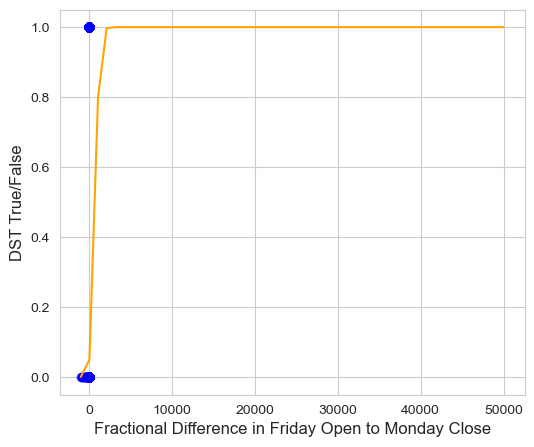

In [34]:
plt.figure(figsize=(6,5))

plt.scatter(tech_train['diff_fomc'], tech_train['y'],alpha=0.4,color='b')

plt.plot(np.linspace(-1000,50000), log_reg.predict_proba(np.linspace(-1000,50000).reshape(-1,1))[:,1], color = 'orange')

plt.xlabel("Fractional Difference in Friday Open to Monday Close", fontsize=12)
plt.ylabel("DST True/False", fontsize=12)
plt.show()

In [30]:
log_reg=LogisticRegression()

In [31]:
log_reg.fit(tech_train[['diff_vol']],tech_train['y'])

LogisticRegression()

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


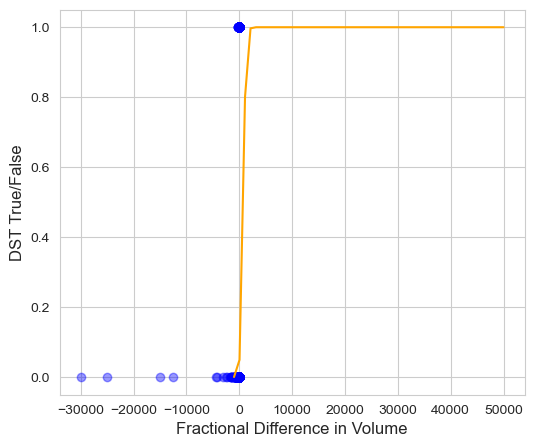

In [33]:
plt.figure(figsize=(6,5))

plt.scatter(tech_train['diff_vol'], tech_train['y'],alpha=0.4,color='b')

plt.plot(np.linspace(-1000,50000), log_reg.predict_proba(np.linspace(-1000,50000).reshape(-1,1))[:,1], color = 'orange')

plt.xlabel("Fractional Difference in Volume", fontsize=12)
plt.ylabel("DST True/False", fontsize=12)
plt.show()

### $k$ Nearest Neighbors

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [52]:
## Make your kfold object
n_splits = 5

kfold = KFold(n_splits=n_splits)

In [37]:
## Fill in the range you want to try for k; say from 1 neighbor to 10
ks = range(1,11)

## Make an array to hold the accuracies
k_all_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(tech_train):
    ## Get the train and holdout sets
    tech_tt = tech_train.iloc[train_index]
    tech_ho = tech_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(tech_tt[metrics],tech_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(tech_ho[metrics])
        
        ## Record the accuracy on the holdout set
        k_all_accs[i,j] = accuracy_score(tech_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

In [39]:
tech_train['y'].value_counts(normalize=True)

y
0    0.957911
1    0.042089
Name: proportion, dtype: float64

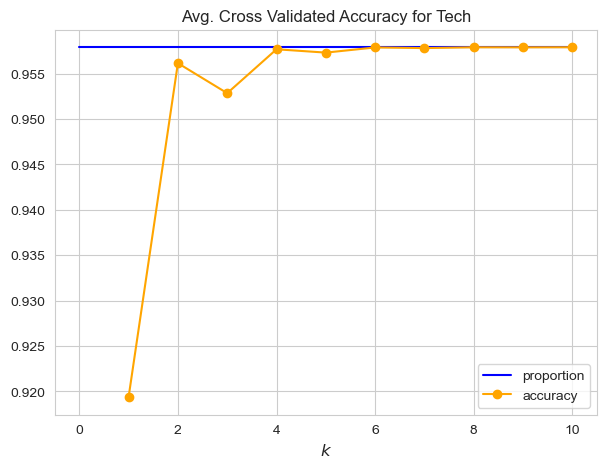

In [41]:
## Plots the accuracies as a function of k
plt.figure(figsize=(7,5))

plt.plot([0,10],[0.957911,0.957911],label='proportion',color='b')

plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o',color='orange',label='accuracy')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.title("Avg. Cross Validated Accuracy for Tech", fontsize=12)

plt.legend()
plt.show()

### Decision Tree, Random Forest, Extra Tree

In [83]:
## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
# from sklearn.metrics import accuracy_score
# from tree_helpers import SkNode, traversable_nodes

In [43]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    random_state= 216)

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 3, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, 
    bootstrap= True, # sampling with replacement
    max_samples = 300, # number of training samples selected with replacement to build tree
    random_state = 216 # for consistency
    )


et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    random_state = 216 
    )

In [44]:
## Fit the models
tree.fit(tech_train[metrics],tech_train['y'])

DecisionTreeClassifier(min_samples_leaf=5, random_state=216)

In [45]:
rf.fit(tech_train[metrics],tech_train['y'])

RandomForestClassifier(max_depth=3, max_features=2, max_samples=300,
                       min_samples_leaf=5, n_estimators=500, random_state=216)

In [46]:
et.fit(tech_train[metrics],tech_train['y'])

ExtraTreesClassifier(max_features=2, min_samples_leaf=5, n_estimators=500,
                     random_state=216)

In [47]:
accs = [accuracy_score(tech_test['y'], tree.predict(tech_test[metrics])),  accuracy_score(tech_test['y'], rf.predict(tech_test[metrics])), accuracy_score(tech_test['y'], et.predict(tech_test[metrics]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.942758
rf,0.957901
et,0.957901


In [49]:
diffs = ['diff_fomc','diff_vol']

In [50]:
## Fit the models
tree.fit(tech_train[diffs],tech_train['y'])
rf.fit(tech_train[diffs],tech_train['y'])
et.fit(tech_train[diffs],tech_train['y'])

ExtraTreesClassifier(max_features=2, min_samples_leaf=5, n_estimators=500,
                     random_state=216)

In [51]:
accs = [accuracy_score(tech_test['y'], tree.predict(tech_test[diffs])),  accuracy_score(tech_test['y'], rf.predict(tech_test[diffs])), accuracy_score(tech_test['y'], et.predict(tech_test[diffs]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.952555
rf,0.957901
et,0.957901


### Balanced Decision Tree, Random Forest, Extra Tree

In [71]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    class_weight='balanced')

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 3, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, 
    bootstrap= True, # sampling with replacement
    max_samples = 300, # number of training samples selected with replacement to build tree
    class_weight='balanced'
    )


et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    class_weight='balanced'
    )

In [103]:
metrics.remove('y')

In [104]:
metrics

['Friday_open',
 'Monday_open',
 'Friday_close',
 'Monday_close',
 'Friday_adj_close',
 'Monday_adj_close',
 'Friday_low',
 'Monday_low',
 'Friday_high',
 'Monday_high',
 'Friday_volume',
 'Monday_volume',
 'diff_fomc']

In [105]:
tree.fit(tech_train[metrics],tech_train['y'])
rf.fit(tech_train[metrics],tech_train['y'])
et.fit(tech_train[metrics],tech_train['y'])

ExtraTreesClassifier(class_weight='balanced', max_features=2,
                     min_samples_leaf=5, n_estimators=500)

In [106]:
tech_test['y'].value_counts()

y
0    77044
1     3385
Name: count, dtype: int64

In [107]:
tree_preds=tree.predict(tech_test[metrics])

confusion_matrix(tech_test['y'], tree_preds)

array([[68074,  8970],
       [ 2969,   416]])

In [108]:
rf_preds=rf.predict(tech_test[metrics])

confusion_matrix(tech_test['y'],rf_preds)

array([[77044,     0],
       [ 3385,     0]])

In [109]:
et_preds=et.predict(tech_test[metrics])

confusion_matrix(tech_test['y'],et_preds)

array([[71688,  5356],
       [ 3157,   228]])

In [110]:
accs = [accuracy_score(tech_test['y'], tree.predict(tech_test[metrics])),  accuracy_score(tech_test['y'], rf.predict(tech_test[metrics])), accuracy_score(tech_test['y'], et.predict(tech_test[metrics]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.851559
rf,0.957913
et,0.894155


In [111]:
prec = [precision_score(tech_test['y'], tree.predict(tech_test[metrics])),  precision_score(tech_test['y'], rf.predict(tech_test[metrics])), precision_score(tech_test['y'], et.predict(tech_test[metrics]))]
pd.DataFrame(prec, index= ['tree', 'rf', 'et'], columns = ['precision'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision
tree,0.044321
rf,0.000000
et,0.040831


In [112]:
rec = [recall_score(tech_test['y'], tree.predict(tech_test[metrics])),  recall_score(tech_test['y'], rf.predict(tech_test[metrics])), recall_score(tech_test['y'], et.predict(tech_test[metrics]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['recall'])

,recall
tree,0.851559
rf,0.957913
et,0.894155


In [113]:
tree.fit(tech_train[diffs],tech_train['y'])
rf.fit(tech_train[diffs],tech_train['y'])
et.fit(tech_train[diffs],tech_train['y'])

ExtraTreesClassifier(class_weight='balanced', max_features=2,
                     min_samples_leaf=5, n_estimators=500)

In [114]:
tree_preds=tree.predict(tech_test[diffs])

confusion_matrix(tech_test['y'], tree_preds)

array([[65447, 11597],
       [ 2880,   505]])

In [115]:
rf_preds=rf.predict(tech_test[diffs])

confusion_matrix(tech_test['y'], rf_preds)

array([[77044,     0],
       [ 3385,     0]])

In [116]:
et_preds=et.predict(tech_test[diffs])

confusion_matrix(tech_test['y'], et_preds)

array([[72498,  4546],
       [ 3167,   218]])

In [117]:
accs = [accuracy_score(tech_test['y'], tree_preds),  accuracy_score(tech_test['y'], rf_preds), accuracy_score(tech_test['y'], et_preds)]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.820003
rf,0.957913
et,0.904102


In [118]:
prec = [precision_score(tech_test['y'], tree_preds),  precision_score(tech_test['y'], rf_preds), precision_score(tech_test['y'], et_preds)]
pd.DataFrame(prec, index= ['tree', 'rf', 'et'], columns = ['precision'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision
tree,0.041729
rf,0.000000
et,0.045760


In [119]:
rec = [recall_score(tech_test['y'], tree_preds),  recall_score(tech_test['y'], rf_preds), recall_score(tech_test['y'], et_preds)]
pd.DataFrame(rec, index= ['tree', 'rf', 'et'], columns = ['recall'])

,recall
tree,0.149188
rf,0.000000
et,0.064402
